# Map-Reduce

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

## Toy-Problem
Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [2]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

## State

In [3]:
import operator
from typing import Annotated, TypedDict
from pydantic import BaseModel

# For Structured outputs from the llm, we will define some schemas
class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int

# Overall State 
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list[str], operator.add]
    best_selected_joke: str

Generate subjects for the jokes 

In [4]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic = state['topic'])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {'subjects':response.subjects}

### Using `Send`
- The first node generates a list of topics -> [subjects]
- We want to generate jokes for all the topics (can be any number of them)
- We use `Send` for this.

We want each subject to go to the same node, but the state changes everytime!

Takes in two args:
1. Node to pass the individual objects to
2. The state to send

Also, Send allows us to send any arbitrary state to the node, even if it does not align with our `OverallState`

In [5]:
from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {'subject': s}) for s in state['subjects']]

In [6]:
continue_to_jokes(state = OverallState(subjects=['Car','Bike']))

[Send(node='generate_joke', arg={'subject': 'Car'}),
 Send(node='generate_joke', arg={'subject': 'Bike'})]

## Joke Generation (Map)

In [17]:
# It will take input from the conditional edge
class JokeState(TypedDict):
    subject: str

# For structured output -> Subclass BaseModel
class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

## Best Joke Selection (Reduce)

In [18]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

## Compile the graph

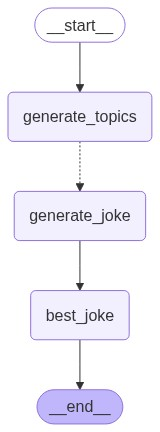

In [22]:
from langgraph.graph import START, END, StateGraph

# Build the graph
graph = StateGraph(OverallState)

# Add Nodes
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

# Add Edges
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ['generate_joke'])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
app

In [20]:
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['mammals', 'reptiles', 'birds']}}
{'generate_joke': {'jokes': ["Why don't scientists trust atoms when it comes to mammals? Because they make up everything, even the fur!"]}}
{'generate_joke': {'jokes': ["Why do seagulls fly over the ocean? Because if they flew over the bay, they'd be bagels!"]}}
{'generate_joke': {'jokes': ["Why don't reptiles ever get lost? Because they always follow the 'scale' of the map!"]}}
{'best_joke': {'best_selected_joke': "Why do seagulls fly over the ocean? Because if they flew over the bay, they'd be bagels!"}}
